##### Проект: Статистический анализ данных сервиса проката самокатов

##### Задача: ответить на вопросы продакт-менеджеров сервиса проката самокатов:  
    
- Тратят ли пользователи с подпиской больше времени на поездки?
- Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
- Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Проверить гипотезу.

##### Состав данных о пользователях сервиса users_go.csv:
    
-**user_id** - 	уникальный идентификатор пользователя,  
-**name**   -	имя пользователя,  
-**age**     -	возраст,  
-**city**    -	город,  
-**subscription_type**   -	тип подписки (free, ultra).
    
Состав данных о поездках rides_go.csv:
    
-**user_id**    -	уникальный идентификатор пользователя,  
-**distance**   -	расстояние, которое пользователь проехал в текущей сессии (в метрах),  
-**duration**   -	продолжительность сессии (в минутах),  
-**date**       -	дата совершения поездки.
    
Состав данных о подписках сервиса subscriptions_go.csv:
    
-**subscription_type**   -	тип подписки,  
-**minute_price**        -	стоимость одной минуты поездки по данной подписке,  
-**start_ride_price**    -	стоимость начала поездки,  
-**subscription_fee**    -	стоимость ежемесячного платежа.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as sp

#### Шаг 1. Загрузка данных

Считываем исходные данные в формате CSV, сохраняем их в датафреймы.

In [2]:
try:
    users = pd.read_csv('C:/Users/bny_7/datasets/users_go.csv', sep=',')
except:
    users = pd.read_csv('/datasets/users_go.csv', sep=',')
display(users.head())
try:
    rides = pd.read_csv('C:/Users/bny_7/datasets/rides_go.csv', sep=',')
except:
    rides = pd.read_csv('/datasets/rides_go.csv', sep=',')
display(rides.head())
try:
    subscriptions = pd.read_csv('C:/Users/bny_7/datasets/subscriptions_go.csv',sep=',')
except:
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv',sep=',')
display(subscriptions.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Отображаем статистику по каждому датафрейму

In [3]:
display(users.info())
display(rides.info())
display(subscriptions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

Анализируя полученную информацию о наборах данных, делаем выводы:
- пропущенных значений в наборах нет, общее количество значений по каждому полю внутри наборов одинаковое,
- все поля наборов имеют правильный тип данных, кроме поля со временем в наборе rides.

#### Шаг 2. Предобработка данных

<div style="background-color:lavender; color:#black; text-align:center; padding:2%">
    
##### **Нина:** Найдем минимальное и максимальное значение дат в данных:

In [4]:
display(np.max(rides['date']),np.min(rides['date']))

'2021-12-30'

'2021-01-01'

Все данные в наборе относятся к 2021 году, так что можно провести агрегацию данных по месяцам.
Приводим тип данных для поля rides.date к типу даты pandas.
Добавляем новый столбец с номером месяца на основе столбца rides.date.

In [5]:
rides['date'] = pd.to_datetime(rides['date'])
rides['month'] = rides['date'].dt.month
display(rides.head())

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Проверяем наличие пропущенных значений:

In [6]:
display(users.isna().sum())
display(rides.isna().sum())
display(subscriptions.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Отсутствующих значений в наборах нет. Проверяем наличие дубликатов:

In [7]:
display(users.duplicated().sum())
display(rides.duplicated().sum())
display(subscriptions.duplicated().sum())

31

0

0

Дубликаты обнаружились в наборе users. Удаляем их. Выполняем проверку.

In [8]:
users = users.drop_duplicates()
display(users.duplicated().sum())

0

##### Данные очищены и подготовлены для иследования:
    
- тип данных приведен к правильному,
- дубликаты удалены,
- пропуски отсутствуют.

#### Шаг 3. Исследовательский анализ данных

Проанализируем данные. Для этого построим график, отображающий количество пользователей сервисом в городах

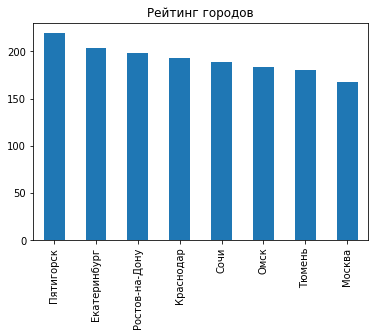

In [9]:
users['city'].value_counts().sort_values(ascending=False).plot(kind='bar', title='Рейтинг городов')
plt.xlabel='города'
plt.ylabel='Кол-во пользователей'

Из графика видно, что Пятигорск лидирует по количеству самокатчиков, а Москва занимает последнее место в этом списке.
Продолжаем анализ. Посмотрим на соотношение пользователей с подпиской и без подписки

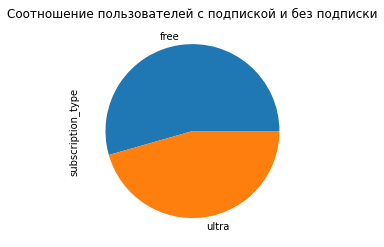

In [10]:
(users['subscription_type']
     .value_counts()
     .sort_values(ascending=False)
     .plot(kind='pie', title='Соотношение пользователей с подпиской и без подписки')
)
plt.xlabel='Тип подписки'
plt.ylabel='Кол-во пользователей'

Получается, что любителей кататься без регистрации приблизительно на 100 человек больше, нежели зарегистрировавшихся.
Изучим возраст катающихся

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

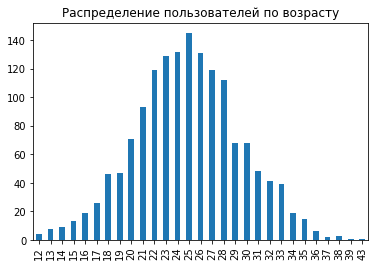

In [11]:
(users['age']
    .value_counts()
    .sort_index()
    .plot(kind='bar', title='Распределение пользователей по возрасту')
)
plt.xlabel='Возраст пользователей'
plt.ylabel='Кол-во пользователей'
users['age'].describe()

Самым молодым пользователям по 12 лет, а самая взрослым - 43. Распределение по возрастным группам представляет собой график нормального распределения с выраженным центром, подтвержденным медианным значением, - 25 лет.
Посмотрим, какое расстояние преодолевает пользователь за одну поездку

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

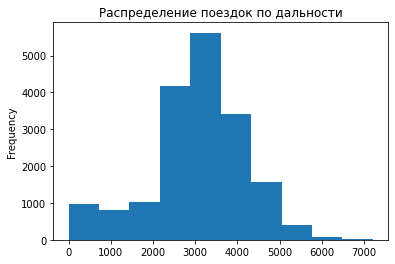

In [12]:
rides['distance'].plot(kind='hist', bins=10, title='Распределение поездок по дальности')
plt.xlabel='Длина поездки'
plt.ylabel='Кол-во поездок'
rides['distance'].describe()

Видим, что дальность поездок варируется от 0 до 7211 метров, в среднем длительность поездки
составляет 3133,6 метра. График распределения длин неравномерный слева.
Посмотрим на продолжительность поездок

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

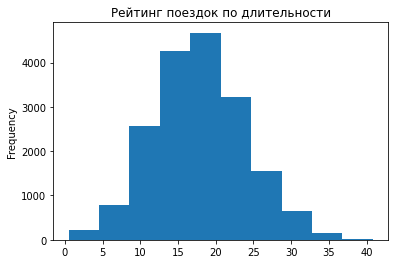

In [13]:
rides['duration'].plot(kind='hist', bins=10, title='Рейтинг поездок по длительности')
plt.xlabel='Длительность поездки'
plt.ylabel='Кол-во поездок'
rides['duration'].describe()

Общая продолжительность поездок варируется от 1 минуты до 41-42 минут, не много.
Средняя продолжительность поездки составляет 17,68 минут.

##### Общие выводы по результатм исследования данных:
    
- Пятигорск - лидер по количеству пользователей сервиса, Москва - аутсайдер.
- Количество пользователей без регистрации больше (+ 100 человек), чем зарегистрированных.
- Средний возраст пользователей - 25 лет. Минимальный - 12 лет, максимальный - 43 года.
- Средняя дальность поездки составила 3133,6 метра. Минимальная - чуть больше 0, максимальная - 7211 метров.
- Средняя длительность поездок составляет 17,68 минут. Минимальная - 1 минута, максимальная - 42 минуты.

#### Шаг 4. Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм

In [14]:
u_r=pd.merge(users, rides, how='left', on='user_id')
usr_rds_sbscr=pd.merge(u_r,subscriptions, how='left', on='subscription_type')
display(usr_rds_sbscr)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


Наборы объединены в один датафрейм usr_rds_sbscr.
Разделим данные на 2 датафрейма - пользователи с подпиской и без.

In [15]:
ultra=usr_rds_sbscr[usr_rds_sbscr['subscription_type']=='ultra']
display(ultra)
free=usr_rds_sbscr[usr_rds_sbscr['subscription_type']=='free']
display(free)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


Общее количество строк в двух датафремах совпадает. Разделение прошло успешно.
Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

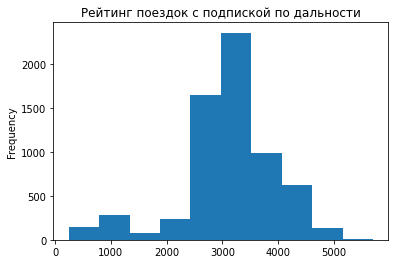

In [16]:
ultra['distance'].plot(kind='hist', title='Рейтинг поездок с подпиской по дальности')
plt.xlabel='Дальность поездки с подпиской'
plt.ylabel='Кол-во поездок с подпиской'
ultra['distance'].describe()

Средняя длительность поездки по подписке составляет 3115,44 метра

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

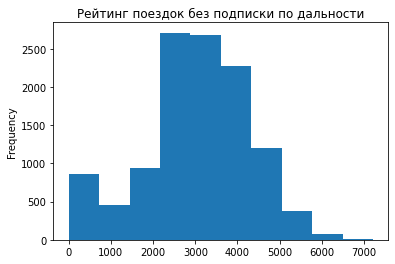

In [17]:
free['distance'].plot(kind='hist', title='Рейтинг поездок без подписки по дальности')
plt.xlabel='Дальность поездки без подписки'
plt.ylabel='Кол-во поездок без подписки'
free['distance'].describe()

А средняя длительность поездки без подписки составляет 3045,46 метра, что приблизительно на 70 метров
меньше, чем средняя длительность поездок по подписке. Разница небольшая.

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

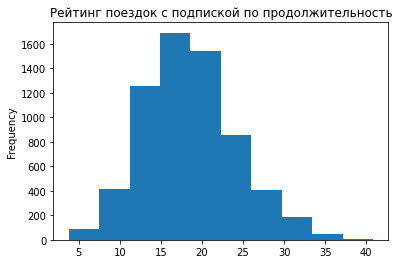

In [18]:
ultra['duration'].plot(kind='hist', title='Рейтинг поездок с подпиской по продолжительность')
plt.xlabel='Продолжительность поездки с подпиской'
plt.ylabel='Кол-во поездок с подпиской'
ultra['duration'].describe()

Средняя продолжительность поездки по подписке составляет 18,54 минуты

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

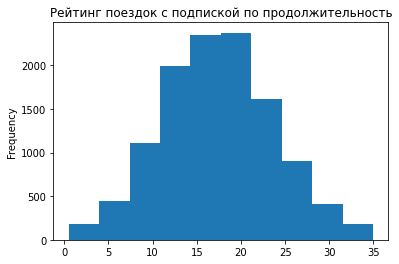

In [19]:
(free['duration']
    .plot(kind='hist',
          xlabel='Продолжительность поездки с подпиской',
          ylabel='Кол-во поездок с подпиской',
          title='Рейтинг поездок с подпиской по продолжительность')
)
plt.xlabel='Продолжительность поездки с подпиской'
plt.ylabel='Кол-во поездок с подпиской'
free['duration'].describe()

Средняя продолжительность поездки по подписке составляет 17,39 минуты и это на 1,15 минуты меньше, чем с подпиской.
Это тоже несущественная разница.

##### Выводы по результатам объединения наборов исходных данных и проведения дополнительного анализа: 
- Средняя длительность поездки пользователей с подпиской составила 3115,44 метра.
- Средняя длительность поездки пользователей без подписки составила 3045,46 метра.
  Это приблизительно на 70 метров меньше, чем средняя длительность поездок по подписке. Разница небольшая.
- Средняя продолжительность поездки по подписке составила 18,54 минуты.
- Средняя продолжительность поездки по подписке составила 17,39 минуты.
  Это на 1,15 минуты меньше, чем с подпиской. Это тоже несущественная разница.
    
Пользователи с подпиской ездят дольше и дальше!

#### Шаг 5. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными. Рассчитаем:
- суммарное расстояние,
- количество поездок,
- суммарное время для каждого пользователя за каждый месяц.

В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь.
Продолжительность каждой поездки в каждой строке исходного датафрейма округляем до следующего целого числа.

In [20]:
rides_agg = pd.pivot_table(
   usr_rds_sbscr,
   index=['user_id','month'], 
   aggfunc={'distance': np.sum,
             'duration': np.sum,
             'minute_price': np.mean,
             'start_ride_price': np.mean,
             'user_id': len,
             'subscription_fee': np.average}
).rename(columns={'user_id': 'count'})
rides_agg['profit'] = (
     rides_agg['start_ride_price']*rides_agg['count']+
     rides_agg['minute_price']*np.ceil(rides_agg['duration'])+
     rides_agg['subscription_fee']
)
display(rides_agg)

distance   duration  minute_price  start_ride_price  \
user_id month                                                            
1       1       7027.511294  41.416640             6                 0   
        4        754.159807   6.232113             6                 0   
        8       6723.470560  44.776802             6                 0   
        10      5809.911100  31.578017             6                 0   
        11      7003.499363  53.397424             6                 0   
...                     ...        ...           ...               ...   
1534    6       3409.468534  24.812678             8                50   
        8       7622.453034  47.205960             8                50   
        9       4928.173852  22.560373             8                50   
        11     13350.015305  76.342174             8                50   
        12      2371.711192  15.893917             8                50   

               subscription_fee  count  profit  
user_id month                                   
1       1                   199      2   451.0  
        4                   199      1   241.0  
        8                   199      2   469.0  
        10                  199      2   391.0  
        11                  199      3   523.0  
...                         ...    ...     ...  
1534    6                     0      2   300.0  
        8                     0      2   484.0  
        9                     0      1   234.0  
        11                    0      4   816.0  
        12                    0      1   178.0  

[11331 rows x 7 columns]

#### Шаг 6. Проверка гипотез

Определим, тратят ли пользователи с подпиской больше времени на поездки. Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим эту гипотезу.
Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

##### Проверяем гипотезу
    
Поскольку выборки независимые, то воспользуемся методом **st.ttest_ind** для проверки гипотезы.  
Наша **нулевая** гипотеза - **Пользователи с подпиской тратят столько же времени на поездки, как и пользователи без подписки**.  
Альтернативная гипотеза - 'Пользователи с подпиской тратят больше времени на поездки'.  
Уровень статистической значимости примем 0,05.

In [21]:
print('Среднее выборки с подпиской:', ultra['duration'].mean())
print('Среднее выборки без подписки:', free['duration'].mean())
H0='Пользователи с подпиской тратят столько же времени на поездки, как и пользователи без подписки'
H1='Пользователи с подпиской тратят больше времени на поездки'
alpha=0.05
results=sp.ttest_ind(
    ultra['duration'],
    free['duration'],
    equal_var=True,
    alternative='greater'
)
print('p-значение:', results.pvalue)

if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее выборки с подпиской: 18.54198516280583
Среднее выборки без подписки: 17.39090929866399
p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Получается, что наша нулевая гипотеза не подтвердилась, хоть цифры по средним значениям говорят об обратном.  
Следовательно, **пользователи с подпиской тратят больше времени на поездки**.

3130 метров — оптимальное с точки зрения износа самоката. Проверим гипотезу, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.  

##### Проверяем гипотезу
    
Поскольку мы сравниваем среднее выборки с заданным значением, то воспользуемся методом **np.ttest_1sam**.  

Наша **нулевая** гипотеза - **Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку,
    равно 3130 метров**.  

Альтернативная гипотеза - 'Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку,
    больше 3130 метров'.  

Уровень статистической значимости примем 0,05.

In [22]:
print('Среднее выборки с подпиской:', ultra['distance'].mean())
H0='Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров'
H1='Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров'
alpha=0.05
value=3130
results=sp.ttest_1samp(
    ultra['distance'],
    value,
    alternative='greater'
)
print('p-значение:', results.pvalue)

if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее выборки с подпиской: 3115.4453880370247
p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Наша гипотеза подтвердилась, среднее расстояние, которое проезжает пользователь с подпиской, равно оптимальному в 3130 метров, то есть не превышает его.

Проверим следующую гипотезу: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Для этого рассчитаем суммарную выручку по месяцам для пользователей с подпиской и без двухвыборочным t-тестом для независимых выборок.

##### Проверяем гипотезу

Поскольку выборки независимые, то воспользуемся методом **st.ttest_ind** для проверки гипотезы.

Наша **нулевая** гипотеза - **Помесячная выручка от пользователей с подпиской по месяцам равна помесячной выручке от пользователей без подписки**.  

Альтернативная гипотеза - 'Помесячная выручка от пользователей с подпиской по месяцам выше, чем помесячная выручка от пользователей без подписки'.  

Уровень статистической значимости примем 0,05.

Средняя месячная выручка от проката с подпиской: 361.48180013236265
Средняя месячная выручка от проката без подписки: 325.84289496910856
p-значение: 2.8130926188487286e-35
Отвергаем нулевую гипотезу


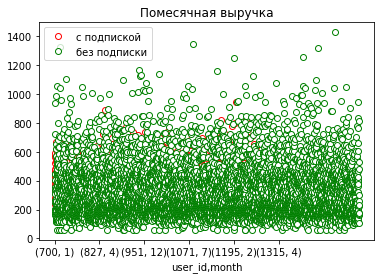

In [23]:
profit_ultra=rides_agg.loc[rides_agg['subscription_fee']>0,'profit']
profit_free=rides_agg.loc[rides_agg['subscription_fee']==0,'profit']
profit_ultra.plot(x=0, marker='o',
                  linestyle='', color='r',markerfacecolor='w',
                  title='Помесячная выручка', label='с подпиской')
profit_free.plot(x=0, marker='o',
                 linestyle='',color='g', markerfacecolor='w',
                 label='без подписки')
plt.legend()
print('Средняя месячная выручка от проката с подпиской:', profit_ultra.mean())
print('Средняя месячная выручка от проката без подписки:', profit_free.mean())
H0='Помесячная выручка от пользователей с подпиской по месяцам равна помесячной выручке от пользователей без подписки'
H1='Помесячная выручка от пользователей с подпиской по месяцам выше, чем помесячная выручка от пользователей без подписки'
alpha=0.05
results=sp.ttest_ind(
    profit_ultra,
    profit_free,
    equal_var=True,    
    alternative='greater'
)
print('p-значение:', results.pvalue)

if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Нулевая гипотеза отвергнута, а это значит, что прокат с подпиской более выгоден в сравнении с прокатом без подписки.

- Вопрос: Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?
- Ответ: поскольку данные будут зависимы, так как представляют собой выборку из одной генеральной совокупности до изменения и после, то будем использовать двухвыборочный t-тест для зависимых выборок, чтобы проверить гипотезу.
Полагаем, что 0-я гипотеза - количество обращений в техподдержку не изменилось, а альтернативная гипотеза - количество обращений в техподдержку уменьшилось. Измпользуем значение параметра alternative='less'.

##### Итоговый вывод:
    
В результате исследовательского анализа предоставленных данных мы подтвердили следующие выводы:
- Средняя длительность поездки пользователей с подпиской составила 3115,44 метра.  
- Средняя длительность поездки пользователей без подписки составила 3045,46 метра.  
    Это приблизительно на 70 метров меньше, чем средняя длительность поездок по подписке. Разница небольшая.  
- Средняя продолжительность поездки по подписке составила 18,54 минуты.  
- Средняя продолжительность поездки по подписке составила 17,39 минуты.  
    Это на 1,15 минуты меньше, чем с подпиской. Это тоже несущественная разница.
    
**Промежуточный вывод: пользователи с подпиской ездят дольше и дальше!**  
    
Для ответа на вопросы продакт-менеджеров мы выдвигали гипотезы и получили следующие результаты: 
    
- Тратят ли пользователи с подпиской больше времени на поездки?  
    - **Да, пользователи с подпиской тратят больше времени на поездки**. 
    
    
- Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
    - **Да, среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров**.  
    
    
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?  
    - **Да, помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки**.